<a href="https://colab.research.google.com/github/submolok/Hyperspectral-CNN-LSTM/blob/main/CNN%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, TimeDistributed, Reshape, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import h5py
import requests
import os
import scipy.io

# Define dataset URL (Indian Pines Dataset from Purdue University)
data_url = "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat"
labels_url = "http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat"
data_path = "Indian_pines_corrected.mat"
labels_path = "Indian_pines_gt.mat"

# Download dataset
def download_file(url, output_path):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(output_path, 'wb') as f:
            for chunk in response.iter_content(1024):
                f.write(chunk)
        print(f"Download successful: {output_path}")
    else:
        print(f"Failed to download: {response.status_code}")

download_file(data_url, data_path)
download_file(labels_url, labels_path)

# Load dataset
def load_hyperspectral_data(data_file, labels_file):
    data = scipy.io.loadmat(data_file)['indian_pines_corrected']
    labels = scipy.io.loadmat(labels_file)['indian_pines_gt']
    return data, labels

X, y = load_hyperspectral_data(data_path, labels_path)

# Reshape and preprocess data
X = X.reshape(X.shape[0] * X.shape[1], X.shape[2])  # Reshape to (num_samples, num_bands)
y = y.reshape(-1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape for CNN input (add spatial dimensions)
X_train = X_train.reshape(-1, 1, X_train.shape[1], 1) # Reshape for CNN: (samples, height, width, channels)
X_test = X_test.reshape(-1, 1, X_test.shape[1], 1)   # Reshape for CNN: (samples, height, width, channels)

# Model Definition
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])) # Adjust input shape

# CNN Feature Extractor
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((1, 1))(x)  # Update pooling size to avoid reducing the spatial dimensions drastically
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 1))(x)  # Update pooling size to avoid reducing the spatial dimensions drastically
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Calculate the correct shape for Reshape layer
cnn_output_shape = x.shape[1]  # This will be the flattened size

# Reshape for RNN input (using TimeDistributed)
x = Reshape((1, cnn_output_shape))(x)  # Reshape to (1, cnn_output_shape)

# RNN for Spectral Data Processing (using TimeDistributed)
x = TimeDistributed(Dense(128, activation='relu'))(x)  # Adding a Dense layer to match the expected LSTM input shape
x = LSTM(64, return_sequences=True)(x)
x = LSTM(32)(x)

# Output layer
output_layer = Dense(len(np.unique(y)), activation='softmax')(x)

# Compile Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the Model
history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=16)

# Evaluate
accuracy = model.evaluate(X_test, y_test)[1]
print(f"Model Accuracy: {accuracy:.2f}")


Download successful: Indian_pines_corrected.mat
Download successful: Indian_pines_gt.mat
Epoch 1/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - accuracy: 0.4967 - loss: 2.0287 - val_accuracy: 0.5215 - val_loss: 1.8134
Epoch 2/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.5153 - loss: 1.8277 - val_accuracy: 0.5215 - val_loss: 1.8085
Epoch 3/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 80s 38ms/step - accuracy: 0.5119 - loss: 1.8321 - val_accuracy: 0.5215 - val_loss: 1.8106
Epoch 4/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.5065 - loss: 1.8461 - val_accuracy: 0.5215 - val_loss: 1.8090
Epoch 5/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step - accuracy: 0.5067 - loss: 1.8412 - val_accuracy: 0.5215 - val_loss: 1.8113
Epoch 6/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 83s 41ms/step - accuracy: 0.5156 - loss: 1.8273 - val_accuracy: 0.5215 - val_loss: 1.8103
Epoch 7/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 81s 40ms/step - accuracy: 0.5149 - loss: 1.8174 - val_accuracy: 0.5215 - val_

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import scipy.io

# --- Load the Indian Pines Dataset ---
def load_indian_pines_data(data_path, labels_path):
    data = scipy.io.loadmat(data_path)['indian_pines_corrected']
    labels = scipy.io.loadmat(labels_path)['indian_pines_gt']
    return data, labels

# Define dataset paths
data_path = "Indian_pines_corrected.mat"
labels_path = "Indian_pines_gt.mat"

# Load the dataset
X, y = load_indian_pines_data(data_path, labels_path)

# Reshape the data to (num_samples, num_bands)
X = X.reshape(X.shape[0] * X.shape[1], X.shape[2])
y = y.reshape(-1)

# Remove pixels with label 0 (unlabeled)
labeled_indices = y != 0
X = X[labeled_indices]
y = y[labeled_indices]

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Normalize the data to [0, 1]
X = X / np.max(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape for CNN input (add spatial dimensions)
X_train = X_train.reshape(-1, 1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, 1, X_test.shape[1], 1)

# --- Data Augmentation ---
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# --- Feature Extraction using ResNet50 ---
img_height, img_width = 224, 224  # ResNet50's expected input size

# Resize images to 224x224
X_train_resized = np.array([cv2.resize(img, (img_width, img_height)) for img in X_train])
X_test_resized = np.array([cv2.resize(img, (img_width, img_height)) for img in X_test])

# Check and add the missing channel dimension if necessary
if len(X_train_resized.shape) == 3:
    X_train_resized = np.expand_dims(X_train_resized, axis=-1)
    X_test_resized = np.expand_dims(X_test_resized, axis=-1)

# Convert grayscale to RGB if necessary
if X_train_resized.shape[-1] == 1:
    X_train_resized = np.repeat(X_train_resized, 3, axis=-1)
    X_test_resized = np.repeat(X_test_resized, 3, axis=-1)

# Perform data augmentation on training data using the RESIZED data
train_augmented = datagen.flow(X_train_resized, y_train, batch_size=16)  # Use X_train_resized

# Load ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(len(np.unique(y_train)), activation='softmax')(x)

# Create the model
new_model = Model(inputs=base_model.input, outputs=output_layer)

# Compile and train the model
new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
new_model.fit(train_augmented, validation_data=(X_test_resized, y_test), epochs=2)

# --- Morphological Operations ---
kernel = np.ones((3, 3), np.uint8)
X_train_processed = np.array([cv2.morphologyEx(img.astype(np.uint8), cv2.MORPH_OPEN, kernel) for img in X_train_resized])
X_test_processed = np.array([cv2.morphologyEx(img.astype(np.uint8), cv2.MORPH_OPEN, kernel) for img in X_test_resized])

# --- Texture Features (Simplified) ---
def get_texture_features(image):
    # Example feature: mean and standard deviation of pixel values
    mean = np.mean(image)
    std = np.std(image)
    return [mean, std]

X_train_texture = np.array([get_texture_features(img) for img in X_train_processed])
X_test_texture = np.array([get_texture_features(img) for img in X_test_processed])

# Reshape texture features to match the dimensions of the processed images
X_train_texture = X_train_texture.reshape((X_train_texture.shape[0], 1, 1, X_train_texture.shape[1]))
X_test_texture = X_test_texture.reshape((X_test_texture.shape[0], 1, 1, X_test_texture.shape[1]))

# Combine texture features with spectral features (processed images)
X_train_combined = np.concatenate((X_train_processed, np.tile(X_train_texture, (1, img_height, img_width, 1))), axis=-1)
X_test_combined = np.concatenate((X_test_processed, np.tile(X_test_texture, (1, img_height, img_width, 1))), axis=-1)

# --- Define a New Model for Combined Features ---
# Input shape for the new model (processed image + texture features)
input_shape = (img_height, img_width, X_train_combined.shape[-1])

# Load ResNet50 as the base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom layers on top of ResNet50
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(len(np.unique(y_train)), activation='softmax')(x)

# Create the new model
combined_model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
combined_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- Train the Combined Model ---
combined_model.fit(X_train_combined, y_train, validation_data=(X_test_combined, y_test), epochs=2, batch_size=16)

# --- Evaluate the Model ---
# Evaluate the model on the test data
test_loss, test_accuracy = combined_model.evaluate(X_test_combined, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# --- Save the Model ---
# Save the trained model for future use
combined_model.save('combined_features_model.h5')

# --- Make Predictions ---
# Example: Predict on the test data
predictions = combined_model.predict(X_test_combined)
predicted_classes = np.argmax(predictions, axis=1)

# Print predicted classes
print("Predicted Classes:", predicted_classes)

In [ ]:
!pip install spectral

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, TimeDistributed, Reshape, Input, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import requests
import os
import scipy.io
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from spectral import principal_components


# Define dataset URL (Indian Pines Dataset from Purdue University)
data_url = "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat"
labels_url = "http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat"
data_path = "Indian_pines_corrected.mat"
labels_path = "Indian_pines_gt.mat"


# --- Data Preprocessing ---
# 1. Dimensionality Reduction (PCA)
pc = principal_components(X)
X_pca = pc.reduce(num=30).transform(X)  # Reduce to 30 principal components

# 2. Reshape and scale data
X_pca = X_pca.reshape(X_pca.shape[0], 1, X_pca.shape[1], 1)
scaler = StandardScaler()
X_pca = scaler.fit_transform(X_pca.reshape(-1, X_pca.shape[-1])).reshape(X_pca.shape)

# 3. Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# --- Model Definition ---
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))

# CNN Feature Extractor
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)  # Add Batch Normalization
x = MaxPooling2D((1, 1))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)  # Add Batch Normalization
x = MaxPooling2D((1, 1))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Increased dropout rate

# Reshape for RNN input
x = Reshape((1, x.shape[1]))(x)

# RNN for Spectral Data Processing
x = LSTM(128, return_sequences=True)(x)
x = LSTM(64)(x)

# Output layer
output_layer = Dense(len(np.unique(y)), activation='softmax')(x)

# --- Compile Model ---
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- Train the Model ---
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)  # Increased epochs and batch size

# ... (rest of the code for plotting and confusion matrix remains the same) ...

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 3.4 MB/s eta 0:00:00


<ipython-input-5-3fc6590cf392>:31: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  pc = principal_components(X)


Epoch 1/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5619 - loss: 1.4938 - val_accuracy: 0.6402 - val_loss: 1.0083
Epoch 2/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.6395 - loss: 1.0093 - val_accuracy: 0.6675 - val_loss: 0.9057
Epoch 3/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.6536 - loss: 0.9519 - val_accuracy: 0.6863 - val_loss: 0.8550
Epoch 4/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.6649 - loss: 0.9145 - val_accuracy: 0.6956 - val_loss: 0.8228
Epoch 5/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.6849 - loss: 0.8714 - val_accuracy: 0.7039 - val_loss: 0.7996
Epoch 6/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6830 - loss: 0.8536 - val_accuracy: 0.6982 - val_loss: 0.7916
Epoch 7/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.6899 - loss: 0.8437 - val_accuracy: 0.7120 - val_loss: 0.7778
Epoch 8/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.6970 - loss: 0.8244 - 

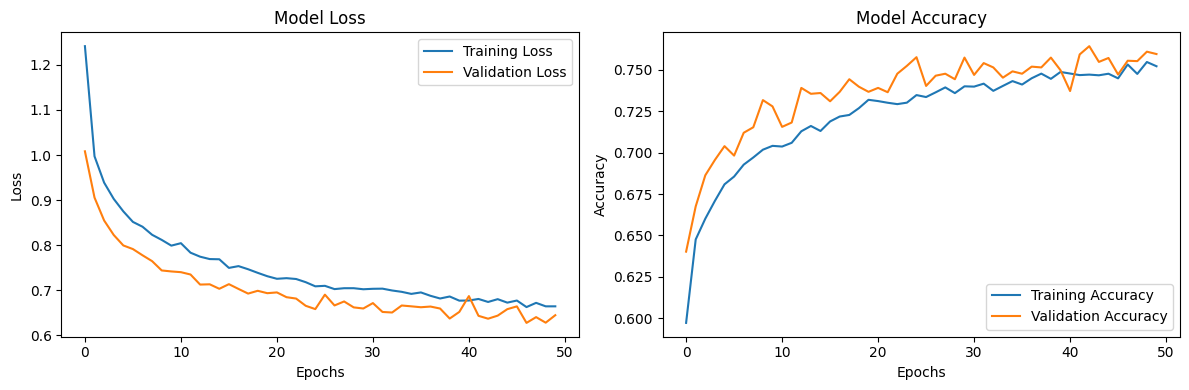

132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


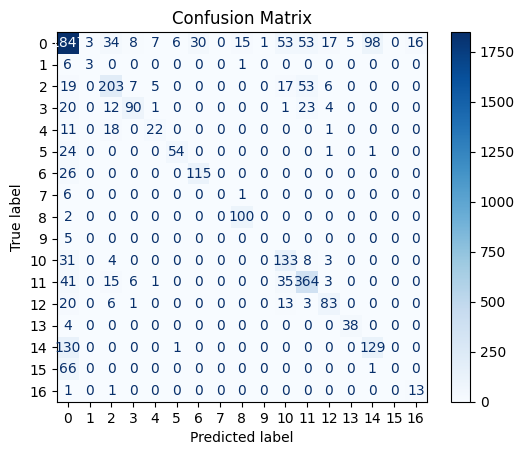

In [ ]:
!pip install spectral

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, TimeDistributed, Reshape, Input, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import requests
import os
import scipy.io
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from spectral import principal_components

def plot_training_curves(history):
    """Plots training and validation curves (loss and accuracy)."""
    training_metrics = history.history

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(training_metrics['loss'], label='Training Loss')
    plt.plot(training_metrics['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(training_metrics['accuracy'], label='Training Accuracy')
    plt.plot(training_metrics['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, X_test, y_test):
    """Plots the confusion matrix."""
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_test, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# --- Call Plotting Functions ---
plot_training_curves(history)
plot_confusion_matrix(model, X_test, y_test)

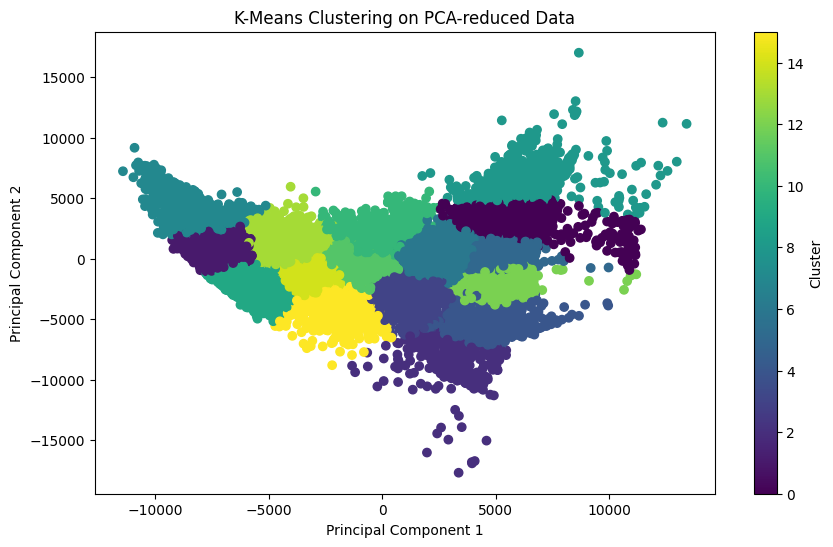

Explained Variance Ratio: [6.84937994e-01 2.35313708e-01 1.49635476e-02 8.21541515e-03
 6.95011265e-03 5.17010703e-03 3.99681431e-03 3.62359687e-03
 3.07127396e-03 2.93211894e-03 2.67352983e-03 2.49230109e-03
 2.24688362e-03 1.89388747e-03 1.69433609e-03 1.56043467e-03
 1.53162480e-03 1.35012976e-03 1.00139015e-03 9.24874864e-04
 8.47883989e-04 7.64383272e-04 6.64597189e-04 6.45674327e-04
 6.16359544e-04 5.61408075e-04 5.43161049e-04 5.15584986e-04
 4.21073872e-04 3.65029916e-04]
Cluster Centers: [[ 6.07711373e+03  2.85793736e+03  1.69303659e+02 -5.73026238e+02
   2.36257915e+02  1.75338845e+02  1.90590475e+02 -1.99057206e+02
  -2.10378867e+01  3.35766182e+01 -1.22841914e+00 -5.12865457e+01
  -2.81896509e+01 -9.64458558e+00 -3.02312543e+01 -4.37674724e+01
   3.31258568e+01  6.57448445e+00  2.38398138e+01 -3.14870044e+01
  -9.38108504e+00  6.90292392e+00 -5.59334534e+00  1.35603122e+01
  -2.32322227e+01  2.40355010e+00  7.18269640e-01  8.99418391e+00
   1.18321488e+01  5.47740516e-01]
 

In [ ]:
# --- Pattern Recognition using PCA and K-Means Clustering ---

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Apply PCA for dimensionality reduction
pca = PCA(n_components=30)  # Reduce to 30 principal components
X_pca = pca.fit_transform(X)

# Perform K-Means clustering
n_clusters = 16  # Number of clusters (adjust based on the dataset)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X_pca)

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('K-Means Clustering on PCA-reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Add the cluster labels to the original dataset
X_clustered = np.hstack((X, labels.reshape(-1, 1)))

# Print the explained variance ratio of the principal components
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

# Print the cluster centers
cluster_centers = kmeans.cluster_centers_
print("Cluster Centers:", cluster_centers)

# --- End of Pattern Recognition Code ---

Silhouette Score for Spectral Clustering: 0.16351675987805914


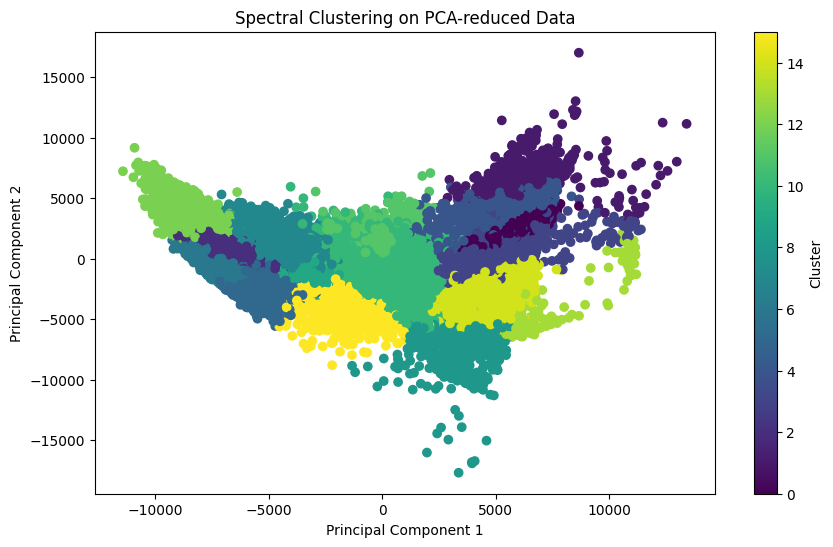

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

# Perform Spectral Clustering
n_clusters = 16  # Number of clusters (adjust based on the dataset)
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
labels = spectral_clustering.fit_predict(X_pca)

# Evaluate clustering using Silhouette Score
silhouette_avg = silhouette_score(X_pca, labels)
print(f"Silhouette Score for Spectral Clustering: {silhouette_avg}")

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('Spectral Clustering on PCA-reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

Epoch 1/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9582046.0000 - val_loss: 9500176.0000
Epoch 2/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9583082.0000 - val_loss: 9500176.0000
Epoch 3/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9575550.0000 - val_loss: 9500176.0000
Epoch 4/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9562740.0000 - val_loss: 9500176.0000
Epoch 5/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9582330.0000 - val_loss: 9500176.0000
Epoch 6/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9560826.0000 - val_loss: 9500176.0000
Epoch 7/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9571312.0000 - val_loss: 9500176.0000
Epoch 8/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9567411.0000 - val_loss: 9500176.0000
Epoch 9/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9599960.0000 - val_loss: 9500176.0000
Epoch 10/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9573370.0000 - val_loss: 9500176.0000
Epoch 11/50
526/526

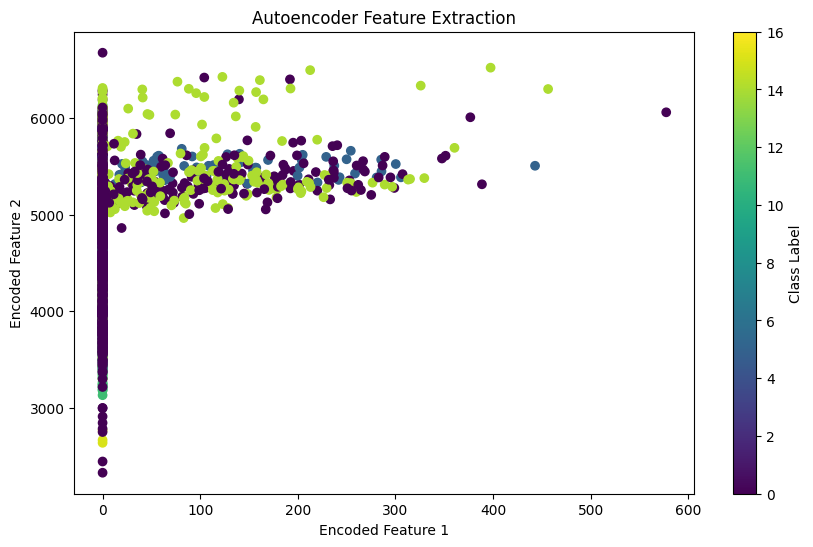

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define the autoencoder
input_dim = X.shape[1]
encoding_dim = 30  # Reduced dimensionality

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X, X, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

# Extract features using the encoder
X_encoded = encoder.predict(X)

# Visualize the encoded features
plt.figure(figsize=(10, 6))
plt.scatter(X_encoded[:, 0], X_encoded[:, 1], c=y, cmap='viridis', marker='o')
plt.title('Autoencoder Feature Extraction')
plt.xlabel('Encoded Feature 1')
plt.ylabel('Encoded Feature 2')
plt.colorbar(label='Class Label')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Random Forest Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      2193
           1       1.00      0.60      0.75        10
           2       0.84      0.74      0.79       310
           3       0.75      0.69      0.72       151
           4       0.79      0.50      0.61        52
           5       0.98      0.61      0.75        80
           6       0.92      0.71      0.80       141
           7       0.80      0.57      0.67         7
           8       0.90      0.89      0.90       102
           9       0.00      0.00      0.00         5
          10       0.72      0.77      0.74       179
          11       0.77      0.86      0.81       465
          12       0.83      0.66      0.73       126
          13       0.89      0.79      0.84        42
          14       0.71      0.46      0.56       260
          15       0.00      0.00      0.00        67
          16       0.75      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


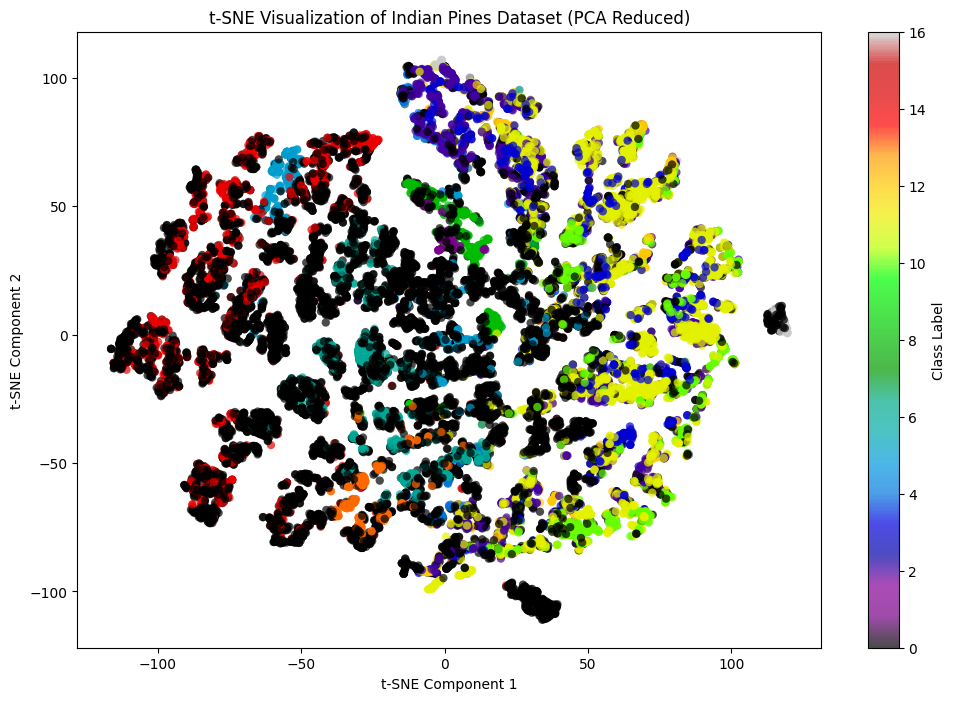

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming X_pca and y are already preprocessed from previous cells
# Flatten PCA data for t-SNE
X_pca_flat = X_pca.reshape(X_pca.shape[0], -1)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_pca_flat)

# Plot the visualization
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='nipy_spectral',
                      alpha=0.7, edgecolors='none')
plt.colorbar(scatter, label='Class Label')
plt.title('t-SNE Visualization of Indian Pines Dataset (PCA Reduced)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()